In [1]:
#!pip install xgboost lightgbm seaborn
#!pip install mlflow optuna-dashboard optuna-integration

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/c3/eb/496aa2f5d356af4185f770bc76055307f8d1870e11016b10fd779b21769c/xgboost-2.0.3-py3-none-manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for lightgbm from https://files.pythonhosted.org/packages/ba/11/cb8b67f3cbdca05b59a032bb57963d4fe8c8d18c3870f30bed005b7f174d/lightgbm-4.3.0-py3-none-manylinux_2_28_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 4.3 MB/s eta 0:00:00:00:010:02m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 7.7 MB/s eta 0:00:00:00:0100:01


In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, Draw, PandasTools
from rdkit.Chem.Draw import IPythonConsole
from rdkit.ML.Descriptors import MoleculeDescriptors
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, LeaveOneOut,KFold,cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from SAscore import sascorer
from IPython.display import Image
from rdkit.Chem.Draw import MolToImage
from tqdm import tqdm
import pickle
import numpy as np
import optuna
from optuna.integration import lightgbm as lgb
#import lightgbm as lgb
import sqlite3
import time
import optuna_dashboard
import os
import mlflow

%matplotlib inline


In [2]:
work_dir  = "240611/"

if not os.path.exists(work_dir):
    os.makedirs(work_dir) 

In [38]:
objective_df = pd.read_csv("./data/CSD_melting_point_revised_C_40_O_10_note_na.csv")
objective_df

,Unnamed: 0.1,Unnamed: 0,列1,refcode,Melting point_original,smiles,MP[K],MP[℃],note
0,0,2,2,AACMHX10,327-328 K,CC(=O)OC(=C1CCCCC1c1ccccc1)c1ccccc1,327.5,54.5,NaN
1,1,4,4,AAMAND,384-386 K,COC1CCC2(C)C(CCC3C2CCC2(C)C3CC2C(C)=O)C1,385.0,112.0,NaN
2,2,47,47,ABDSCE,427-428 K,CC(C)CCCC(C)C1CCC2C3CCC(=O)CC4CC4C(=C)C3CCC12C,427.5,154.5,NaN
3,3,49,49,ABECAL,482-484K,c1ccc(cc1)c1ccc(cc1)c1cc2cc3cccc4cccc(c2c1)c34,483.0,210.0,NaN
4,4,58,58,ABEGIY,388-390 K,O=C1OC(=CC=C1)C=Cc1ccccc1,389.0,116.0,NaN
...,...,...,...,...,...,...,...,...,...
12986,13342,122022,122022,YIVFOC,435-437 K,CC(=C)C(=O)OC1C=C(C)C2(O)CC=C(C)C2C2OC(=O)C(=C...,436.0,163.0,NaN
12987,13343,122025,122025,YOBDUS,505-508 K,CC(C)C1=CCC2(C)CCC3(C)C(CCC4C5(C)CCC(=O)C(C)(C...,506.5,233.5,NaN
12988,13344,122040,122040,ZOCCED,469-471 K,CC1(C)C2CCC3(C)C(O)CCC(O)(CO)C3C12,470.0,197.0,NaN
12989,13345,122069,122069,ZOMVIK,227.8-240.5 deg.C,CC(C)C(=O)CC12CC3C(C=C(C)C)C4(CC5OC14OC5(C)C)C...,507.3,234.3,NaN


count    12991.000000
mean       145.784376
std         62.239810
min       -206.000000
25%        102.200000
50%        141.650000
75%        185.500000
max        570.000000
Name: MP[℃], dtype: float64


<AxesSubplot:xlabel='MP[℃]', ylabel='Count'>

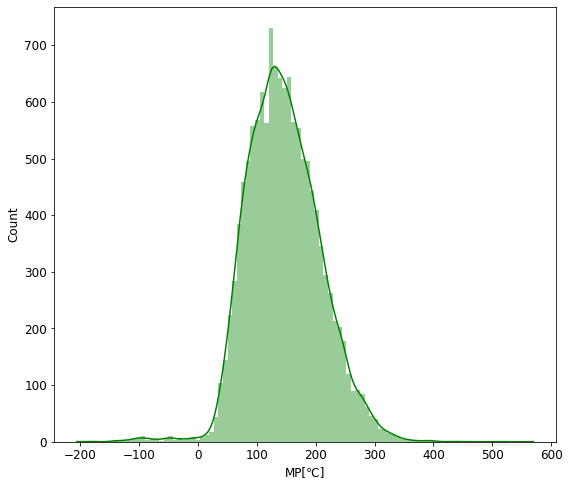

In [39]:
print(objective_df["MP[℃]"].describe())
plt.figure(figsize=(9,8))
sns.histplot(objective_df["MP[℃]"], color="g",kde=True, bins=100, alpha=0.4, edgecolor='none')
#plt.savefig(work_dir + "histplot_mpc_exclude_duplicate.png")

In [40]:
PandasTools.AddMoleculeColumnToFrame(frame=objective_df, smilesCol='smiles')
objective_df['calc_SA_score'] = objective_df.ROMol.map(sascorer.calculateScore)

In [41]:
#SAscoreを3.5未満に設定
objective_df_SAscore_filterd = objective_df[(objective_df['calc_SA_score'] < 3.5)]

count    4683.000000
mean      137.010616
std        66.284409
min      -183.450000
25%        94.000000
50%       132.500000
75%       176.500000
max       570.000000
Name: MP[℃], dtype: float64


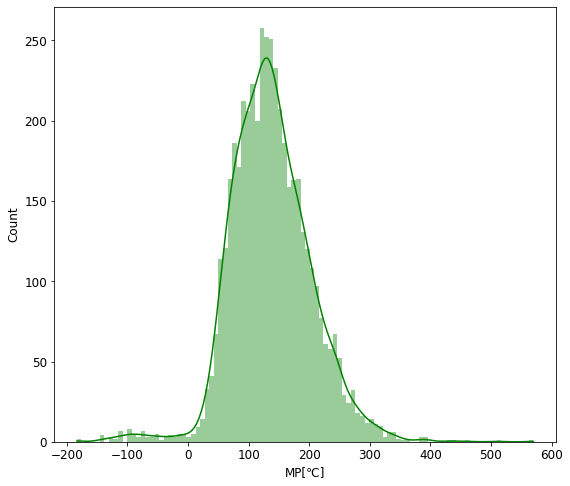

In [43]:
print(objective_df_SAscore_filterd["MP[℃]"].describe())
plt.figure(figsize=(9,8))
sns.histplot(objective_df_SAscore_filterd["MP[℃]"], color="g",kde=True, bins=100, alpha=0.4, edgecolor='none')
plt.savefig(work_dir + "histplot_mpc_exclude_duplicate.png")

## RDkit descriptors

In [45]:
tqdm.pandas()

# すべてのRDKit記述子を取得
descriptor_names = [desc_name[0] for desc_name in Descriptors._descList]

# 記述子計算関数
def calculate_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        calculator = MoleculeDescriptors.MolecularDescriptorCalculator(descriptor_names)
        descriptors = calculator.CalcDescriptors(mol)
        return descriptors
    else:
        return [np.nan] * len(descriptor_names)

# 記述子の計算
descriptors = objective_df_SAscore_filterd['smiles'].progress_apply(calculate_descriptors)
descriptors_df = pd.DataFrame(descriptors.tolist(), columns=descriptor_names)


objective_df.to_csv(work_dir + "objective_df_SAscore_filterd.csv", index=False)
print(len(descriptors_df))
descriptors_df.head()


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4683/4683 [00:40<00:00, 114.95it/s]


4683


,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,11.656925,-0.255798,11.656925,0.255798,0.566518,306.405,284.229,306.161980,118,0,...,0,0,0,0,0,0,0,0,0,0
1,2.341340,1.254079,2.341340,1.254079,0.330230,354.452,336.308,354.140851,130,0,...,0,0,0,0,0,0,0,0,0,0
2,10.901050,-0.328508,10.901050,0.328508,0.742293,198.221,188.141,198.068080,74,0,...,0,0,0,0,0,0,0,0,0,0
3,2.408173,0.556508,2.408173,0.556508,0.298453,428.619,396.363,428.250401,164,0,...,0,0,0,0,0,0,0,0,0,0
4,4.250000,1.625000,4.250000,1.625000,0.380040,46.069,40.021,46.041865,20,0,...,0,0,0,0,0,0,0,0,0,0


## Mordred descriptors

In [18]:
#mordred descriptors

from mordred import Calculator, descriptors
from rdkit import Chem
import pandas as pd
from tqdm import tqdm

# Mordredの記述子計算器を初期化
calc = Calculator(descriptors, ignore_3D=True)

# SMILES文字列からRDKitの分子オブジェクトを生成する関数
def smiles_to_mol(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError(f"Invalid SMILES string: {smiles}")
    return mol

# DataFrameの'smiles'列から分子オブジェクトのリストを生成
molecules = [smiles_to_mol(smiles) for smiles in tqdm(filtered_CHO_exclude_duplicate['smiles'], desc="Converting SMILES to molecules")]

# 記述子を計算
descriptors_df_mordred = calc.pandas(molecules)

# 計算された記述子のDataFrameを表示
print(len(descriptors_df_mordred))
descriptors_df_mordred.head()

 46%|████▌     | 2660/5807 [06:30<07:50,  6.69it/s]

/home/jovyan/.py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 51%|█████     | 2947/5807 [07:04<06:01,  7.92it/s]

/home/jovyan/.py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|██████████| 5807/5807 [13:12<00:00,  7.33it/s]


5807


,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,14.495357,2.351365,4.70273,14.495357,1.31776,3.342101,...,9.284055,41.607772,146.073165,6.955865,140,15,56.0,65.0,3.083333,2.472222
1,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,24.960666,2.551131,5.102261,24.960666,1.386704,3.875135,...,10.218773,52.256986,230.073165,8.216899,511,35,104.0,130.0,4.277778,3.916667
2,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,1,0,15.557342,2.535126,4.824413,15.557342,1.296445,3.482037,...,9.679531,63.499094,162.068080,7.366731,187,17,64.0,78.0,4.034722,2.666667
3,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,17.057488,2.383554,4.767108,17.057488,1.312114,3.498646,...,9.487138,44.505731,176.120115,6.073107,234,18,66.0,76.0,3.673611,2.916667
4,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,12.857279,2.21432,4.428639,12.857279,1.285728,3.188884,...,8.703009,38.792641,138.068080,6.903404,121,11,44.0,48.0,3.722222,2.444444


In [19]:
# 文字列が含まれるカラムを除外する関数
def remove_string_columns(df):
    non_string_columns = df.select_dtypes(exclude=['object'])
    return non_string_columns

# 文字列が含まれるカラムを除外
descriptors_df_mordred_dropna = remove_string_columns(descriptors_df_mordred).dropna()
descriptors_df_mordred_dropna

,nAcid,nBase,nAromAtom,nAromBond,nAtom,nHeavyAtom,nSpiro,nBridgehead,nHetero,nH,...,SRW09,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb2
0,0,0,6,6,21,11,0,0,1,10,...,0.000000,9.284055,41.607772,146.073165,6.955865,140,15,56.0,65.0,2.472222
1,0,0,16,19,28,18,0,0,1,10,...,0.000000,10.218773,52.256986,230.073165,8.216899,511,35,104.0,130.0,3.916667
2,1,0,6,6,22,12,0,0,2,10,...,7.916807,9.679531,63.499094,162.068080,7.366731,187,17,64.0,78.0,2.666667
3,0,0,6,6,29,13,0,0,1,16,...,0.000000,9.487138,44.505731,176.120115,6.073107,234,18,66.0,76.0,2.916667
4,0,0,6,6,20,10,0,0,2,10,...,0.000000,8.703009,38.792641,138.068080,6.903404,121,11,44.0,48.0,2.444444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5802,0,0,7,7,15,9,0,0,2,6,...,5.093750,8.418256,44.763033,122.036779,8.135785,83,12,40.0,43.0,2.111111
5803,0,0,0,0,72,28,0,0,1,44,...,7.065613,10.317615,77.794958,384.339216,5.338045,2214,45,146.0,172.0,6.125000
5804,0,0,6,6,86,34,0,0,3,52,...,0.000000,10.363157,69.994315,472.391646,5.492926,4371,52,168.0,191.0,7.541667
5805,0,0,6,6,79,33,0,0,2,46,...,0.000000,10.182217,68.463046,450.349781,5.700630,4278,48,158.0,178.0,7.500000


In [20]:
filtered_CHO_desc = pd.concat([filtered_CHO_exclude_duplicate, descriptors_df_mordred_dropna], axis=1)
filtered_CHO_desc_dropna  = filtered_CHO_desc.dropna()
filtered_CHO_desc_dropna.to_csv(work_dir + "filtered_CHO_desc_mordred.csv", index=False)

In [22]:
descriptors_df = filtered_CHO_desc_dropna.iloc[:,4:]
descriptors_df

,mpC,nAcid,nBase,nAromAtom,nAromBond,nAtom,nHeavyAtom,nSpiro,nBridgehead,nHetero,...,SRW09,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb2
0,7.00,0.0,0.0,6.0,6.0,21.0,11.0,0.0,0.0,1.0,...,0.000000,9.284055,41.607772,146.073165,6.955865,140.0,15.0,56.0,65.0,2.472222
1,127.00,0.0,0.0,16.0,19.0,28.0,18.0,0.0,0.0,1.0,...,0.000000,10.218773,52.256986,230.073165,8.216899,511.0,35.0,104.0,130.0,3.916667
2,87.00,1.0,0.0,6.0,6.0,22.0,12.0,0.0,0.0,2.0,...,7.916807,9.679531,63.499094,162.068080,7.366731,187.0,17.0,64.0,78.0,2.666667
3,60.00,0.0,0.0,6.0,6.0,29.0,13.0,0.0,0.0,1.0,...,0.000000,9.487138,44.505731,176.120115,6.073107,234.0,18.0,66.0,76.0,2.916667
4,67.00,0.0,0.0,6.0,6.0,20.0,10.0,0.0,0.0,2.0,...,0.000000,8.703009,38.792641,138.068080,6.903404,121.0,11.0,44.0,48.0,2.444444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5802,124.50,0.0,0.0,7.0,7.0,15.0,9.0,0.0,0.0,2.0,...,5.093750,8.418256,44.763033,122.036779,8.135785,83.0,12.0,40.0,43.0,2.111111
5803,197.75,0.0,0.0,0.0,0.0,72.0,28.0,0.0,0.0,1.0,...,7.065613,10.317615,77.794958,384.339216,5.338045,2214.0,45.0,146.0,172.0,6.125000
5804,93.50,0.0,0.0,6.0,6.0,86.0,34.0,0.0,0.0,3.0,...,0.000000,10.363157,69.994315,472.391646,5.492926,4371.0,52.0,168.0,191.0,7.541667
5805,163.00,0.0,0.0,6.0,6.0,79.0,33.0,0.0,0.0,2.0,...,0.000000,10.182217,68.463046,450.349781,5.700630,4278.0,48.0,158.0,178.0,7.500000


## PCA

In [71]:
n_components=30
def pca(descriptors_df,n_components):
    # STANDARDIZATION
    n_components = n_components
    scaler = StandardScaler ()
    xs = scaler.fit_transform (descriptors_df)
    #scaler.fit (x)
    pickle.dump (scaler, open (work_dir + "scaler_fitted.pkl", "wb")) 
    scaler_df = pd.DataFrame (np.stack ([scaler.mean_, scaler.scale_], -1), columns = ["mean", "std"])
    scaler_df.to_csv (work_dir + "./scaler.csv", index = False)

    # PCA
    pca = PCA(n_components = n_components)
    pca_mat = pca.fit_transform (xs)
    #pca.fit (xs)
    pickle.dump (pca, open (work_dir + "pca_fitted.pkl", "wb"))  
    columns = ["PC{}".format (i + 1) for i in range (n_components)]
    pca_df = pd.DataFrame (pca_mat, columns = columns)

    # OBJECTIVE VARIABLE
    # obj = pd.DataFrame (np.stack ([names, cof], -1), columns = ["names", "cof"])
    # obj.index = smiles

    # MAKE NEW DATAFRAME
    # pca_df.index = smiles
    # pca_df = pd.concat ([obj, pca_df], axis = 1)
    print ("SHAPE OF DATAFRAME:       ", pca_df.shape)  
    pca_df.to_csv(work_dir + "pca_df.csv")
    return pca_df,pca


def conform_pca(pca):
    contribution = pca.explained_variance_ratio_

    #累積寄与率
    contribution_sum=[0]*len(contribution)
    contribution_sum[0]=contribution[0]
    for i in range(1,len(contribution)):
        contribution_sum[i] = contribution_sum[i-1] + contribution[i]


    # 累積寄与率を図示する
    cum_con_ratio = np.hstack([0, pca.explained_variance_ratio_]).cumsum()
    plt.figure(figsize=(6, 4))
    plt.plot(cum_con_ratio, 'D-')
    plt.xlabel("Num of PC")
    # plt.xticks(range(n_components +1))
    plt.ylabel("Contribution Rate")
    plt.yticks(np.arange(0,1.05,0.1))
    plt.grid()
    plt.show()
    

SHAPE OF DATAFRAME:        (4683, 30)


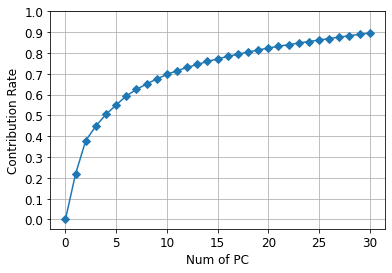

In [47]:
#寄与率
pca_df,pca = pca(descriptors_df,n_components)
conform_pca(pca)

## Train and Predict

In [77]:
import numpy as np
import xgboost as xgb
import sklearn.datasets
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import optuna

def objective(trial):
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dvalid = xgb.DMatrix(valid_x, label=valid_y)

    param = {
        "verbosity": 0,
        "objective": "reg:squarederror",  # 回帰問題用の目的関数
        "tree_method": "exact",
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    bst = xgb.train(param, dtrain, num_boost_round=100)  # num_boost_roundを追加
    preds = bst.predict(dvalid)
    rmse = np.sqrt(mean_squared_error(valid_y, preds))  # RMSEの計算
    return rmse



In [51]:
%%time

SEED=42

pruner = optuna.pruners.MedianPruner(n_warmup_steps=5)

study = optuna.create_study(pruner=pruner,direction='minimize')  # RMSEを最小化
study.optimize(objective, n_trials=100)

# 最適化されたパラメータを出力
print('Number of finished trials:', len(study.trials))
print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))
    
pickle.dump (trial, open (work_dir + "best_model_3.pkl", "wb")) 

[I 2024-06-11 12:43:25,084] A new study created in memory with name: no-name-5e4d9dc4-3cee-42be-89e7-b9c0c89eaf6d
[I 2024-06-11 12:43:25,195] Trial 0 finished with value: 45.33606528394449 and parameters: {'booster': 'gblinear', 'lambda': 6.108590233625478e-05, 'alpha': 3.2295806971907744e-06, 'subsample': 0.5032578900739938, 'colsample_bytree': 0.858560326745808}. Best is trial 0 with value: 45.33606528394449.
[I 2024-06-11 12:43:25,268] Trial 1 finished with value: 45.33614141727409 and parameters: {'booster': 'gblinear', 'lambda': 1.8757652484741137e-07, 'alpha': 1.1471740079716814e-05, 'subsample': 0.28274822005730543, 'colsample_bytree': 0.47607308770994927}. Best is trial 0 with value: 45.33606528394449.
[I 2024-06-11 12:43:28,204] Trial 2 finished with value: 64.74271315900462 and parameters: {'booster': 'dart', 'lambda': 1.4211277897380073e-07, 'alpha': 0.0028345466053680953, 'subsample': 0.6699425584155669, 'colsample_bytree': 0.4158973321188641, 'max_depth': 5, 'min_child_wei

Number of finished trials: 100
Best trial:
  Value: 42.913854906675375
  Params: 
    booster: dart
    lambda: 1.8327402838192045e-06
    alpha: 0.216957775384587
    subsample: 0.25439441456594325
    colsample_bytree: 0.6278666701665533
    max_depth: 9
    min_child_weight: 7
    eta: 0.03932245260849879
    gamma: 0.009736958209842515
    grow_policy: depthwise
    sample_type: uniform
    normalize_type: forest
    rate_drop: 1.7190359952132496e-05
    skip_drop: 0.00021954341642902114
CPU times: user 3h 22min 2s, sys: 14min 54s, total: 3h 36min 56s
Wall time: 4min 34s


In [52]:
def YYplot (y_train, y_test, predy_train, predy_test, f):
    # COEFFICIENT OF DETERMINANT AND ERROR
    trainRMSE = mean_squared_error (y_train, predy_train)
#     trainRMSE = mean_squared_error (y_train, predy_train, squared = False)
    trainMAE = mean_absolute_error (y_train, predy_train)
    trainR2 = r2_score (y_train, predy_train)
    testRMSE = mean_squared_error (y_test, predy_test)
#     testRMSE = mean_squared_error (y_test, predy_test, squared = False)
    testMAE = mean_absolute_error (y_test, predy_test)
    testR2 = r2_score (y_test, predy_test)
    print ("-----------------")
    print (f"Train RMSE {trainRMSE:.3f}")
    print (f"Train MAE  {trainMAE:.3f}")
    print (f"Train R2   {trainR2:.3f}")
    print ("-----------------")     
    print (f"Test  RMSE {testRMSE:.3f}")
    print (f"Test  MAE  {testMAE:.3f}")
    print (f"Test  R2   {testR2  :.3f}")
    print ("-----------------")   
    
    # YY PLOT
    fig = plt.figure (figsize = (8, 8))   
    plt.rcParams["font.size"] = 12 
    plt.scatter (y_train, predy_train, label = "Training data (RMSE = {:.3f}, MAE = {:.3f}, R$^2$ = {:.3f})".format (trainRMSE, trainMAE, trainR2), alpha = 0.5, s = 8)
    plt.scatter (y_test, predy_test, label = "Test data (RMSE = {:.3f}, MAE = {:.3f}, R$^2$ = {:.3f})".format (testRMSE, testMAE, testR2), alpha = 1.0, s = 20)
    plt.legend ()
    ymax = max (list (y_train) + list (y_test) + list (predy_test) + list (predy_test))
    ymin = min (list (y_train) + list (y_test) + list (predy_test) + list (predy_test))
    ymax = ymax + (ymax - ymin) * 0.1
    ymin = ymin - (ymax - ymin) * 0.1
    plt.plot ([ymin, ymax], [ymin, ymax], "k-")
    plt.ylim (ymin, ymax)
    plt.xlim (ymin, ymax)
    plt.xlabel ("Actual values")
    plt.ylabel ("Predicted values")
    fig.savefig (work_dir + f + ".png")  

-----------------
Train RMSE 1042.433
Train MAE  23.791
Train R2   0.764
-----------------
Test  RMSE 1904.929
Test  MAE  33.277
Test  R2   0.556
-----------------


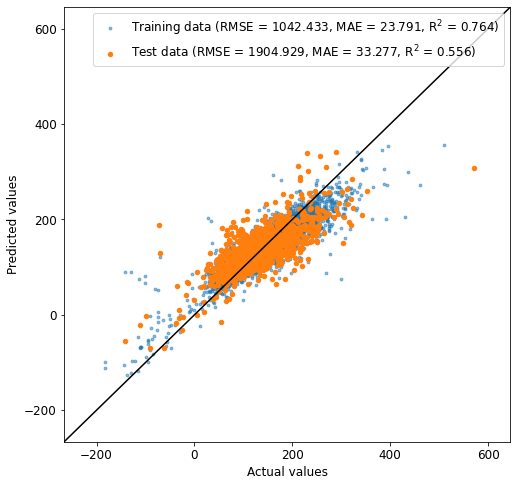

In [53]:
train_x, valid_x, train_y, valid_y = train_test_split(pca_df,objective_df_SAscore_filterd["MP[℃]"], test_size=0.2, random_state=SEED)
param = trial.params
dtrain = xgb.DMatrix(train_x, label=train_y)
dvalid = xgb.DMatrix(valid_x, label=valid_y)


model = xgb.train(param, dtrain, num_boost_round=100)
train_y_pred = model.predict(dtrain)
valid_y_pred = model.predict(dvalid)
YYplot (train_y, valid_y, train_y_pred, valid_y_pred, "xgboost")

## 予測誤差が大きい分子の解析

In [57]:
error = valid_y - valid_y_pred
error_df = pd.DataFrame(error).rename(columns={'MP[℃]': 'Error'})
error_over_50_df = error_df[abs(error_df["Error"]) > 100]
over_50_indices = error_over_50_df.index

objective_df_Error = objective_df.loc[over_50_indices]
objective_df_largeError = pd.concat([objective_df_Error,error_over_50_df],axis=1)
objective_df_largeError_sort = objective_df_largeError.sort_values("Error",ascending=True)
objective_df_largeError_sort

,Unnamed: 0.1,Unnamed: 0,列1,refcode,Melting point_original,smiles,MP[K],MP[℃],note,ROMol,calc_SA_score,Error
9646,9894,88927,88927,SIQJIL,200-203 K,CC(=O)Oc1ccc2c(Oc3cc(OC(C)=O)ccc3C32OC(=O)c2cc...,201.50,-71.50,NaN,<rdkit.Chem.rdchem.Mol object at 0x7fa204ae5cf0>,3.050979,-259.393326
4526,4637,39172,39172,HPCPRA,402-3K,CC(C(O)=O)C1(O)CCCCC1c1ccccc1,202.50,-70.50,NaN,<rdkit.Chem.rdchem.Mol object at 0x7fa2048cd970>,3.308138,-200.274475
271,276,2619,2619,APOTOP,55-57 deg.C,COC(=O)c1c(O)cc(C)c2cc(c3ccccc3)c3ccccc3c12,329.15,56.15,NaN,<rdkit.Chem.rdchem.Mol object at 0x7fa204819660>,2.151465,-125.653970
831,851,7477,7477,BIVZIP,125-30deg.C(dec.),C1=CC2=C3C=C3C3=CC=CC3=C3C=C3C2=C1,350.65,77.65,NaN,<rdkit.Chem.rdchem.Mol object at 0x7fa2047fff20>,1.635991,-116.119180
544,558,5131,5131,BASCIH,380-381 K,c1ccc2c(c1)c1ccccc1c1ccccc1c1ccccc21,380.50,107.50,NaN,<rdkit.Chem.rdchem.Mol object at 0x7fa20481cf90>,1.000000,-110.905838
11597,11915,108214,108214,WUBHIK,340K,CC(=O)CC1(O)C(=O)c2ccccc2c2ccccc12,340.00,67.00,NaN,<rdkit.Chem.rdchem.Mol object at 0x7fa204b50040>,2.667022,-109.839066
9116,9350,84005,84005,RIVJIP,73-75deg.C,COc1ccc(cc1)C1(O)OC(=O)C(=C1Cc1cc(OC)c(OC)c(OC...,347.15,74.15,NaN,<rdkit.Chem.rdchem.Mol object at 0x7fa204af2190>,3.140072,-109.035471
10657,10940,98989,98989,UTAHUU,503-504 K,c1ccc2c(c1)ccc1c3ccc4ccccc4c3c3c4ccccc4ccc3c21,503.50,230.50,NaN,<rdkit.Chem.rdchem.Mol object at 0x7fa204ac3e40>,1.688636,-109.016205
6861,7031,60899,60899,MNMACT,123-4deg.C,CC(=O)OC(c1c(C)ccc2ccccc12)c1c(C)ccc2ccccc12,336.65,63.65,NaN,<rdkit.Chem.rdchem.Mol object at 0x7fa2049b8740>,2.299269,-103.325830
8439,8658,77035,77035,QAMSEF01,483-484 K,c1ccc2c(c1)c1ccc3c4ccccc4C4=C5c6ccccc6c6ccc7c8...,483.50,210.50,NaN,<rdkit.Chem.rdchem.Mol object at 0x7fa20498c4a0>,1.836259,-102.042542


count     25.000000
mean     179.142000
std      144.308654
min      -71.500000
25%       74.150000
50%      184.000000
75%      303.000000
max      570.000000
Name: MP[℃], dtype: float64


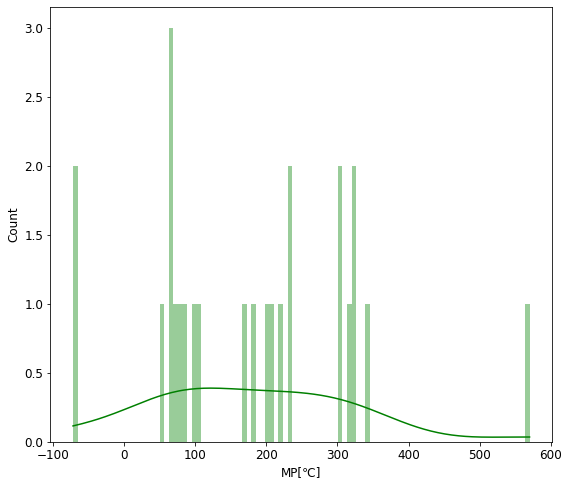

In [58]:
print(objective_df_largeError_sort["MP[℃]"].describe())
plt.figure(figsize=(9,8))
sns.histplot(objective_df_largeError_sort["MP[℃]"], color="g",kde=True, bins=100, alpha=0.4, edgecolor='none')
plt.savefig(work_dir + "histplot_filtered_CHO_exclude_duplicate_largeError_sort.png")

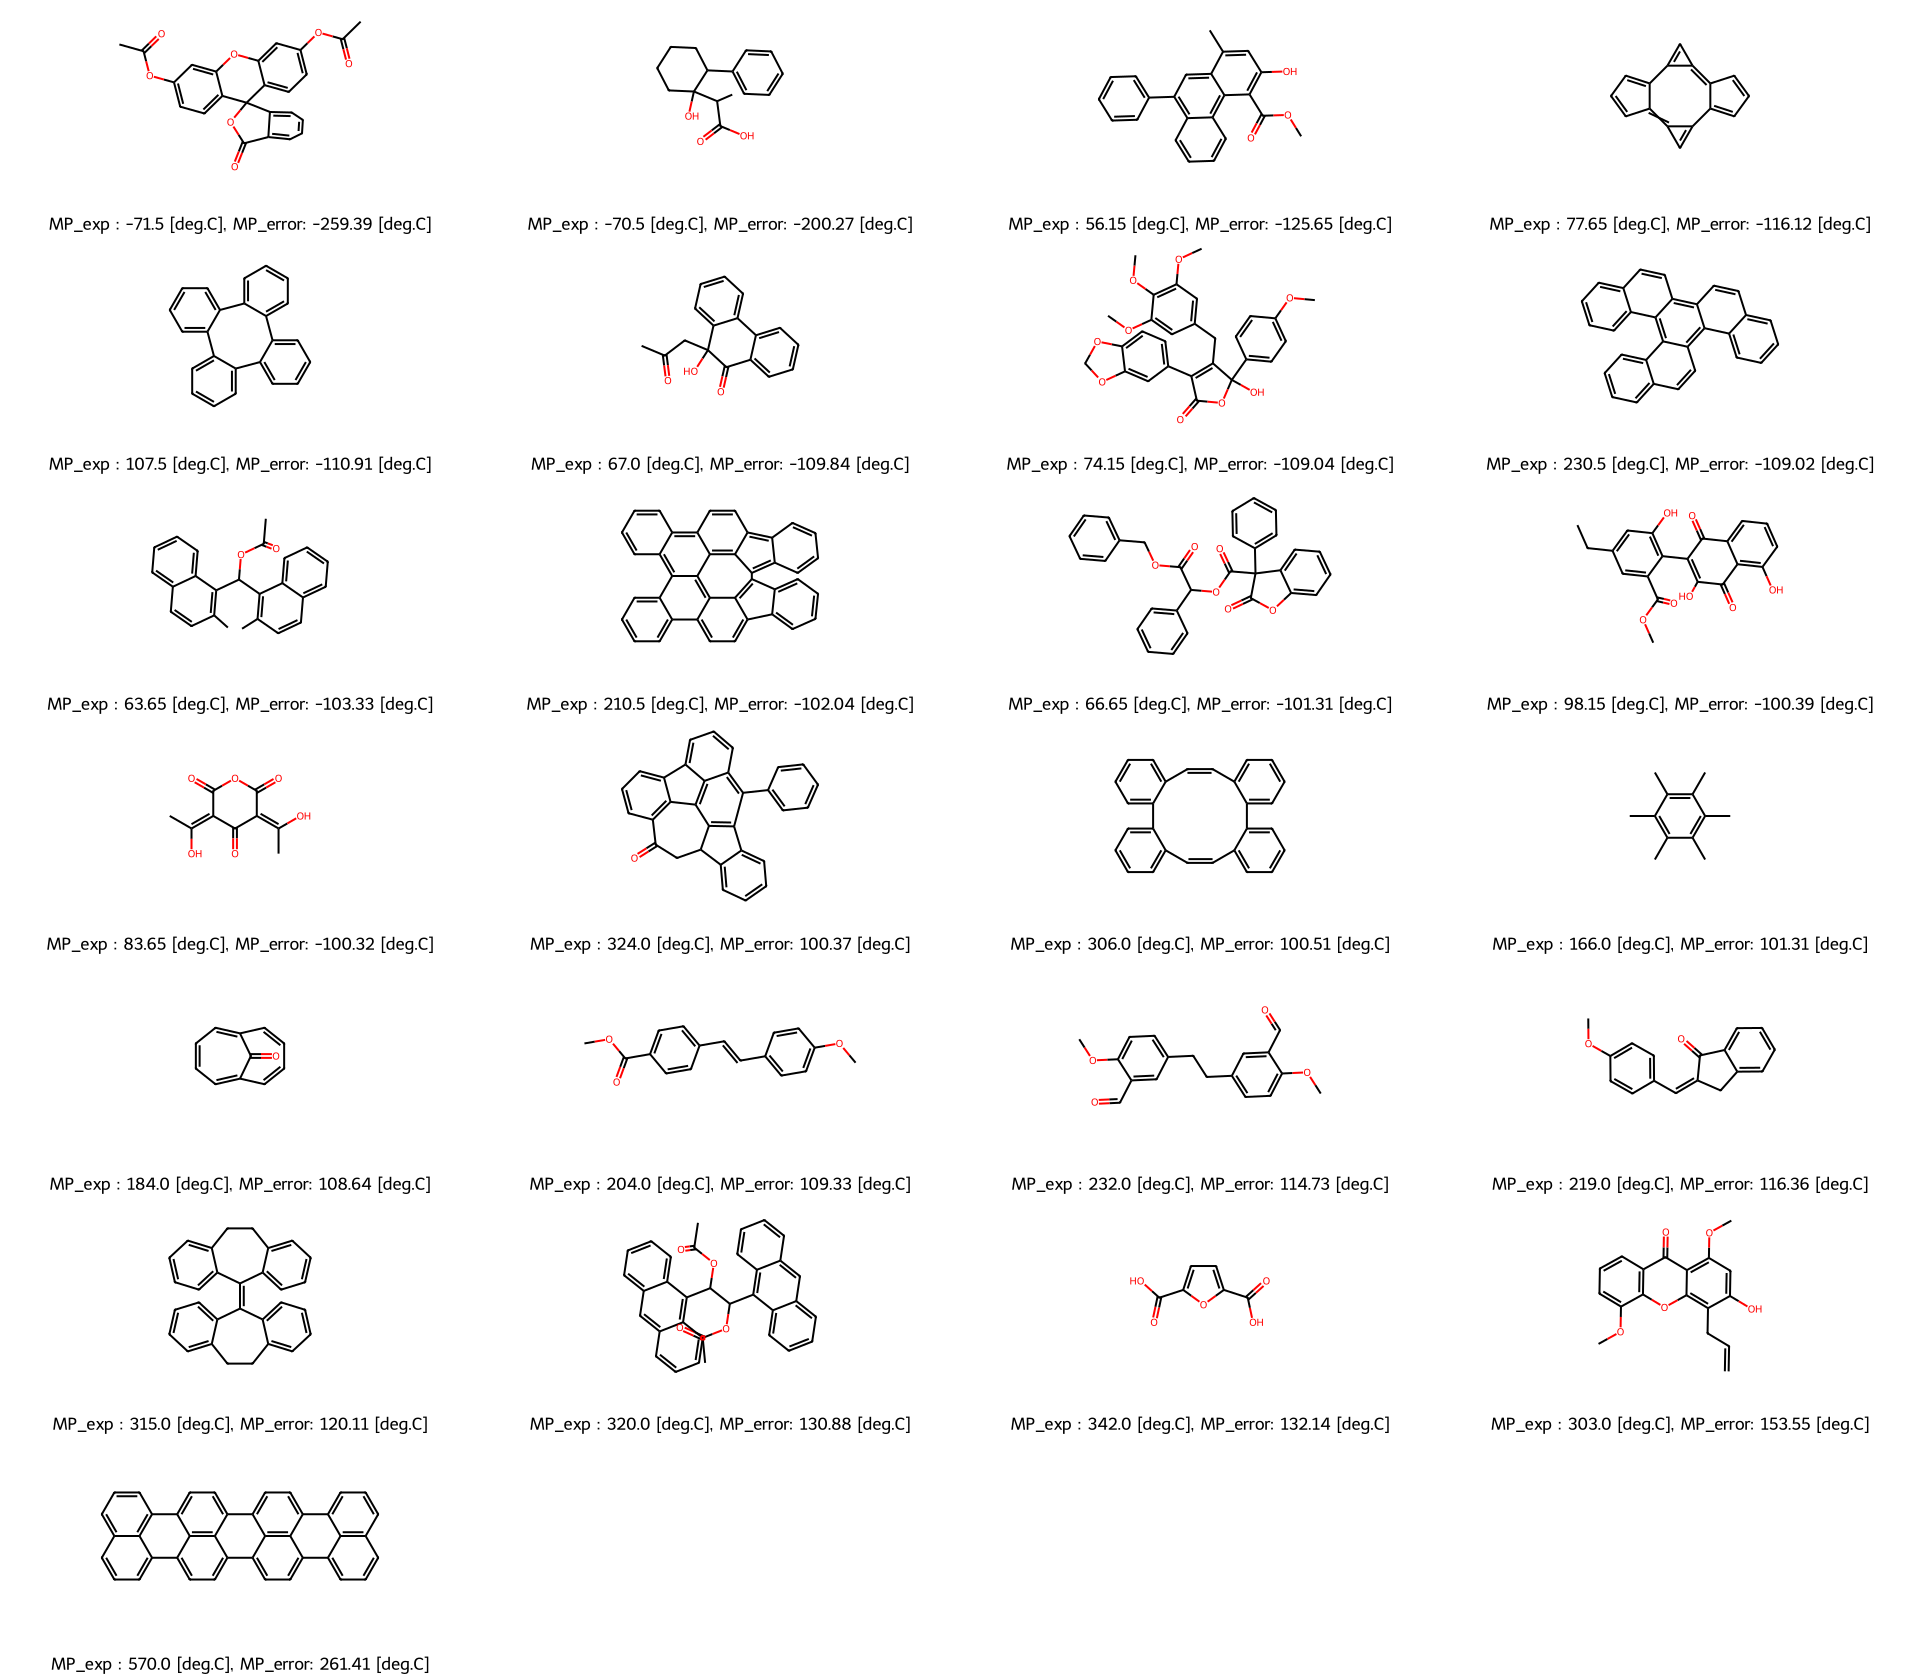

In [59]:
molecules = [Chem.MolFromSmiles(smile) for smile in objective_df_largeError_sort["smiles"]]
legend_list = []

MP_error = objective_df_largeError_sort["Error"].round(2).astype(str).values.flatten().tolist()
MP_exp   = objective_df_largeError_sort["MP[℃]"].round(2).astype(str).values.flatten().tolist()
options = Draw.MolDrawOptions()
options.legendFontSize = 17  # default: 16
options.legendFraction = 0.2
for i in range(len(molecules)) :
    legend_list.append('MP_exp : {} [deg.C], MP_error: {} [deg.C]'.format(MP_exp[i],MP_error[i]))
img = Draw.MolsToGridImage(molecules,molsPerRow=4, subImgSize=(480,240),legends = legend_list,drawOptions=options)
img

In [63]:
new_objective_df = objective_df_SAscore_filterd[~objective_df_SAscore_filterd['refcode'].isin(objective_df_largeError_sort['refcode'])]
new_objective_df

,Unnamed: 0.1,Unnamed: 0,列1,refcode,Melting point_original,smiles,MP[K],MP[℃],note,ROMol,calc_SA_score
0,0,2,2,AACMHX10,327-328 K,CC(=O)OC(=C1CCCCC1c1ccccc1)c1ccccc1,327.50,54.50,NaN,<rdkit.Chem.rdchem.Mol object at 0x7fa20878ecf0>,2.850847
3,3,49,49,ABECAL,482-484K,c1ccc(cc1)c1ccc(cc1)c1cc2cc3cccc4cccc(c2c1)c34,483.00,210.00,NaN,<rdkit.Chem.rdchem.Mol object at 0x7fa20878ec10>,2.457932
4,4,58,58,ABEGIY,388-390 K,O=C1OC(=CC=C1)C=Cc1ccccc1,389.00,116.00,NaN,<rdkit.Chem.rdchem.Mol object at 0x7fa20878edd0>,2.019823
5,5,76,76,ABEKOH,142-146deg.C,CCC1C(CC)c2ccccc2C(=C2CCCc3ccc4ccccc4c23)c2ccc...,417.15,144.15,NaN,<rdkit.Chem.rdchem.Mol object at 0x7fa2087a2040>,3.444277
8,8,107,107,ABEWAG,130 K,COC,130.00,-143.00,NaN,<rdkit.Chem.rdchem.Mol object at 0x7fa2087a2190>,1.956857
...,...,...,...,...,...,...,...,...,...,...,...
12975,13331,121947,121947,SOFFIG,413-414 K,CC(C)(C)c1cc2ccc3c(cc(c4ccccc4)c4cc(C=O)c(c1)c...,413.50,140.50,NaN,<rdkit.Chem.rdchem.Mol object at 0x7fa204b3e4a0>,2.480002
12976,13332,121949,121949,SOFFUS,467-468 K,CC(C)(C)c1cc2ccc3c(cc(c4ccccc4)c4cc(C=Cc5ccccc...,467.50,194.50,NaN,<rdkit.Chem.rdchem.Mol object at 0x7fa204b3e510>,2.567463
12977,13333,121961,121961,TPHBEN07,175 deg.C,c1ccc(cc1)c1cc(cc(c1)c1ccccc1)c1ccccc1,448.15,175.15,NaN,<rdkit.Chem.rdchem.Mol object at 0x7fa204b3e580>,1.061717
12978,13334,121982,121982,VIXYOU,391 K,OC1CCC(CC1)c1ccccc1,391.00,118.00,NaN,<rdkit.Chem.rdchem.Mol object at 0x7fa204b3e5f0>,1.706437


In [68]:
objective_df = new_objective_df

tqdm.pandas()

# すべてのRDKit記述子を取得
descriptor_names = [desc_name[0] for desc_name in Descriptors._descList]

# 記述子計算関数
def calculate_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        calculator = MoleculeDescriptors.MolecularDescriptorCalculator(descriptor_names)
        descriptors = calculator.CalcDescriptors(mol)
        return descriptors
    else:
        return [np.nan] * len(descriptor_names)

# 記述子の計算
descriptors = objective_df['smiles'].progress_apply(calculate_descriptors)
descriptors_df = pd.DataFrame(descriptors.tolist(), columns=descriptor_names)


objective_df.to_csv(work_dir + "new_objective_df.csv", index=False)
print(len(descriptors_df))
descriptors_df

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4658/4658 [00:41<00:00, 112.42it/s]


4658


,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,11.656925,-0.255798,11.656925,0.255798,0.566518,306.405,284.229,306.161980,118,0,...,0,0,0,0,0,0,0,0,0,0
1,2.341340,1.254079,2.341340,1.254079,0.330230,354.452,336.308,354.140851,130,0,...,0,0,0,0,0,0,0,0,0,0
2,10.901050,-0.328508,10.901050,0.328508,0.742293,198.221,188.141,198.068080,74,0,...,0,0,0,0,0,0,0,0,0,0
3,2.408173,0.556508,2.408173,0.556508,0.298453,428.619,396.363,428.250401,164,0,...,0,0,0,0,0,0,0,0,0,0
4,4.250000,1.625000,4.250000,1.625000,0.380040,46.069,40.021,46.041865,20,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4653,12.357592,-0.004956,12.357592,0.004956,0.198902,438.570,412.362,438.198365,164,0,...,0,0,0,0,0,0,0,0,0,0
4654,2.433791,0.050858,2.433791,0.050858,0.162447,512.696,480.440,512.250401,192,0,...,0,0,0,0,0,0,0,0,0,0
4655,2.274907,1.243021,2.274907,1.243021,0.395433,306.408,288.264,306.140851,114,0,...,0,0,0,0,0,0,0,0,0,0
4656,9.373852,-0.041702,9.373852,0.041702,0.697179,176.259,160.131,176.120115,70,0,...,0,0,0,0,0,0,0,0,0,0


SHAPE OF DATAFRAME:        (4658, 30)


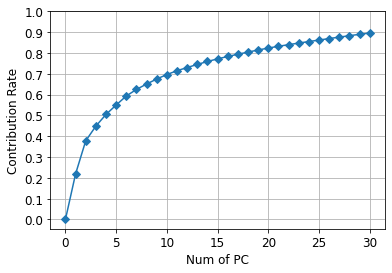

In [72]:
pca_df,pca = pca(descriptors_df,n_components)
conform_pca(pca)

In [79]:
pca_df.shape
objective_df_SAscore_filterd.shape

(4683, 11)

In [80]:
%%time
train_x, valid_x, train_y, valid_y = train_test_split(pca_df,new_objective_df["MP[℃]"], test_size=0.2, random_state=SEED)
SEED=42

pruner = optuna.pruners.MedianPruner(n_warmup_steps=5)

study = optuna.create_study(pruner=pruner,direction='minimize')  # RMSEを最小化
study.optimize(objective, n_trials=100)

# 最適化されたパラメータを出力
print('Number of finished trials:', len(study.trials))
print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))
    
pickle.dump (trial, open (work_dir + "best_model_2.pkl", "wb")) 

[I 2024-06-11 13:04:59,493] A new study created in memory with name: no-name-2b105bce-843c-481c-a0a8-cfed735c4fab
[I 2024-06-11 13:05:01,973] Trial 0 finished with value: 47.65659788515558 and parameters: {'booster': 'dart', 'lambda': 1.565020630824744e-05, 'alpha': 1.6000556034876866e-08, 'subsample': 0.2682313127469533, 'colsample_bytree': 0.5968262785711611, 'max_depth': 7, 'min_child_weight': 6, 'eta': 0.1653528937526405, 'gamma': 1.6011917487561518e-07, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.0016109417522426751, 'skip_drop': 0.00011911703933198975}. Best is trial 0 with value: 47.65659788515558.
[I 2024-06-11 13:05:05,192] Trial 1 finished with value: 63.83811897469337 and parameters: {'booster': 'dart', 'lambda': 0.6568642809469725, 'alpha': 0.007936164838813863, 'subsample': 0.7472255632249893, 'colsample_bytree': 0.5937136763613571, 'max_depth': 5, 'min_child_weight': 3, 'eta': 0.00032860685538409575, 'gamma': 1.57817051

Number of finished trials: 100
Best trial:
  Value: 41.51311712107153
  Params: 
    booster: dart
    lambda: 3.7417183830993917e-06
    alpha: 0.03758187361108954
    subsample: 0.5408097921361532
    colsample_bytree: 0.9505296359782621
    max_depth: 7
    min_child_weight: 3
    eta: 0.07553835761412035
    gamma: 0.01240744942840134
    grow_policy: lossguide
    sample_type: uniform
    normalize_type: tree
    rate_drop: 2.7466936607314358e-08
    skip_drop: 2.226158657210461e-06
CPU times: user 3h 17min 51s, sys: 14min 34s, total: 3h 32min 26s
Wall time: 4min 28s


-----------------
Train RMSE 341.298
Train MAE  14.399
Train R2   0.921
-----------------
Test  RMSE 1798.722
Test  MAE  32.044
Test  R2   0.567
-----------------


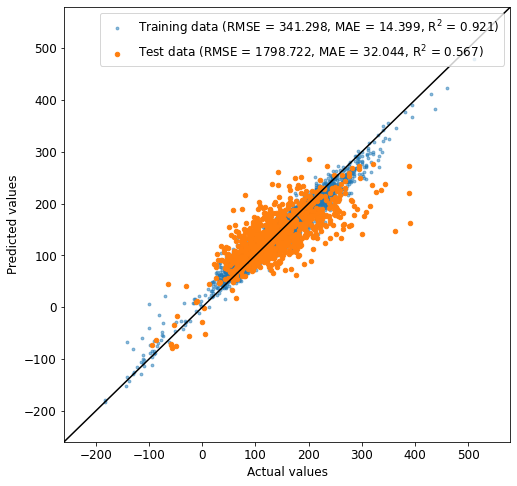

In [81]:

param = trial.params
dtrain = xgb.DMatrix(train_x, label=train_y)
dvalid = xgb.DMatrix(valid_x, label=valid_y)


model = xgb.train(param, dtrain, num_boost_round=100)
train_y_pred = model.predict(dtrain)
valid_y_pred = model.predict(dvalid)
YYplot (train_y, valid_y, train_y_pred, valid_y_pred, "xgboost_2")

In [85]:
error = valid_y - valid_y_pred
error_df = pd.DataFrame(error).rename(columns={'MP[℃]': 'Error'})
error_over_50_df = error_df[abs(error_df["Error"]) > 100]
over_50_indices = error_over_50_df.index

objective_df_Error = new_objective_df.loc[over_50_indices]
objective_df_largeError = pd.concat([objective_df_Error,error_over_50_df],axis=1)
objective_df_largeError_sort = objective_df_largeError.sort_values("Error",ascending=False)
objective_df_largeError_sort

,Unnamed: 0.1,Unnamed: 0,列1,refcode,Melting point_original,smiles,MP[K],MP[℃],note,ROMol,calc_SA_score,Error
8086,8293,73473,73473,PIDZIM,663.8 K,CC(c1cc(C)ccc1O)c1cc(C)ccc1O,663.80,390.80,NaN,<rdkit.Chem.rdchem.Mol object at 0x7fa2049887b0>,2.206830,228.779889
626,640,5782,5782,BEGTIQ,635 K,CC1(OC(=O)c2ccccc2O1)Oc1ccc2ccccc2c1,635.00,362.00,NaN,<rdkit.Chem.rdchem.Mol object at 0x7fa204808430>,2.799902,215.531448
12932,13288,121566,121566,ZZZNKU01,661 K,c1ccc(cc1)c1ccc(cc1)c1ccc(cc1)c1ccc(cc1)c1ccccc1,661.00,388.00,NaN,<rdkit.Chem.rdchem.Mol object at 0x7fa204b42190>,1.000000,167.199570
4051,4149,34550,34550,GUMMUW04,573 K,OC1=C(O)C(=O)C(=O)C1=O,573.00,300.00,NaN,<rdkit.Chem.rdchem.Mol object at 0x7fa2048de660>,2.723941,159.662994
11610,11928,108367,108367,WUHVIE,573-583 K,O=C1C(c2ccccc2)c2c3ccccc3c3ccccc3c2C1c1ccccc1,578.00,305.00,NaN,<rdkit.Chem.rdchem.Mol object at 0x7fa204b505f0>,2.780888,129.543747
7993,8198,72760,72760,PERYTO08,534-535 K,OCC(CO)(CO)CO,534.50,261.50,NaN,<rdkit.Chem.rdchem.Mol object at 0x7fa2049a0e40>,2.951963,127.784927
2265,2315,18620,18620,DIXWUD,581 K,COc1ccccc1c1c2ccccc2c(c2ccccc2OC)c2ccccc12,581.00,308.00,NaN,<rdkit.Chem.rdchem.Mol object at 0x7fa2048a9c80>,1.658897,124.326752
315,324,3131,3131,ASUBAS,589 K,c1ccc(cc1)c1cc2ccc3cc(cc4ccc(c1)c2c34)c1ccccc1,589.00,316.00,NaN,<rdkit.Chem.rdchem.Mol object at 0x7fa2048379e0>,1.637329,119.984039
6399,6552,56040,56040,LIYZIC,552K,Cc1ccc(cc1)C(c1ccccc1)(c1ccc(C)cc1)c1ccc(C)cc1,552.00,279.00,NaN,<rdkit.Chem.rdchem.Mol object at 0x7fa2049b59e0>,1.628045,119.909393
7988,8193,72715,72715,PERLEN05,549K,c1cc2cccc3c4cccc5cccc(c(c1)c23)c45,549.00,276.00,NaN,<rdkit.Chem.rdchem.Mol object at 0x7fa2049a0c10>,1.486118,118.759659


In [88]:
new_objective_df.to_csv("data/CSD_melting_point_C_40_O_10_v2.csv")